# Import Libraries


In [130]:
# Import Libraries
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [131]:
pwd

'/home/shakyafernando/projects/monocular-depth-submodules/depth-anything-v2/notebooks'

# Define Directories

In [132]:
# Specify the path to the depth map you want to analyze
depth_map_directory = '../data/diego/set1/depth-maps/scat-oyster-reef-day/'
depth_map_filename = 'scat_oyster_frame_000001_pred04.png'  # depth map filename
depth_map_path = os.path.join(depth_map_directory, depth_map_filename)

In [133]:
# CSV file path
csv_file_path = '../data/diego/set1/csv/results_scat_oyster.csv'

# Proccessing

### Load and Filter CSV

In [134]:
# Load CSV file
df = pd.read_csv(csv_file_path)
df.head()

,image_name,image_id,depth_map_folder,depth_map_file,annotation_id,category_id,category_name,normalized_depth,z-min,z-max,value_metric
0,scat_oyster_frame_000001.png,14,scat-oyster-reef-day,scat_oyster_frame_000098_pred04.png,43,4,80,0.611892,0.4,20.0,12.393088
1,scat_oyster_frame_000001.png,14,scat-oyster-reef-day,scat_oyster_frame_000098_pred04.png,44,3,70,0.522742,0.4,20.0,10.645733
2,scat_oyster_frame_000001.png,14,scat-oyster-reef-day,scat_oyster_frame_000098_pred04.png,45,2,60,0.421627,0.4,20.0,8.663880
3,scat_oyster_frame_000001.png,14,scat-oyster-reef-day,scat_oyster_frame_000098_pred04.png,46,5,90,0.639455,0.4,20.0,12.933310
4,scat_oyster_frame_000001.png,14,scat-oyster-reef-day,scat_oyster_frame_000098_pred04.png,47,1,50,0.304153,0.4,20.0,6.361395


In [135]:
# Filter rows where 'depth_map_file' matches the depth map filename
matching_rows = df[df['depth_map_file'] == depth_map_filename]

# Extract 'normalized_depth' and 'category_name' values
normalized_depths = matching_rows['normalized_depth'].values
category_names = matching_rows['category_name'].values

### Load depth map

In [136]:
# Load Depth Map
depth_map = cv2.imread(depth_map_path, cv2.IMREAD_UNCHANGED)

In [137]:
# Check if depth map was loaded successfully
if depth_map is None:
    print(f"Failed to load depth map at {depth_map_path}.")
else:
    print(f"Depth map loaded successfully from {depth_map_path}.")

Depth map loaded successfully from ../data/diego/set1/depth-maps/scat-oyster-reef-day/scat_oyster_frame_000001_pred04.png.


### Normalize Depth Map

In [138]:
if depth_map is not None:
    # Normalize depth map values
    if depth_map.dtype == np.uint8:
        depth_values = depth_map.flatten() / 255.0
    else:
        depth_values = depth_map.flatten()

    # Remove zero values
    # depth_values_nonzero = depth_values[depth_values > 0]

### Manually Add Reference Point for Minimum Normalized Value

In [139]:
# Add a new reference point
normalized_depths = np.append(normalized_depths, 0.0)
category_names = np.append(category_names, '10')  # Use '10' Indicating that 10cm (0.1m) is the minimum

## Plot Normalized Histogram

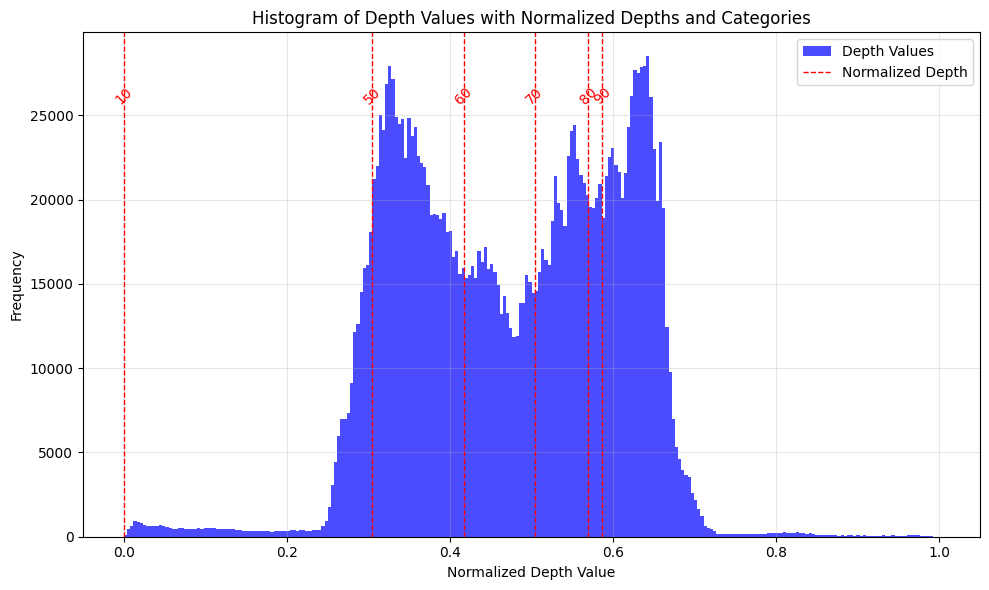

In [140]:
# Plot histogram of depth values
plt.figure(figsize=(10, 6))
plt.hist(depth_values, bins=256, range=(0, 1), color='blue', alpha=0.7, label='Depth Values')

# Plot 'normalized_depth' values on histogram
if len(normalized_depths) > 0:
    for idx, (nd, category_name) in enumerate(zip(normalized_depths, category_names)):
        # Plot vertical line
        plt.axvline(x=nd, color='red', linestyle='dashed', linewidth=1, label='Normalized Depth' if idx == 0 else None)
        # Annotate with category name
        max_count = np.histogram(depth_values, bins=256, range=(0, 1))[0].max()
        plt.text(nd, max_count * 0.9, category_name, color='red', rotation=45, fontsize=10, ha='center')
else:
    print(f"No matching 'normalized_depth' values found in CSV for {depth_map_filename}.")

# Plot graph
plt.title('Histogram of Depth Values with Normalized Depths and Categories')
plt.xlabel('Normalized Depth Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Normalized to Metric Values Histogram

In [141]:
# Metric depths for each category_name
# Keys as strings
category_metric_depths = {
    "10": 0.1,  # Added Manually
    "50": 0.5,
    "60": 0.6,
    "70": 0.7,
    "80": 0.8,
    "90": 0.9,
}

### Match Categories with Metric Depths

In [142]:
# Initialize lists to hold valid data
metric_depths = []
valid_normalized_depths = []
valid_category_names = []

# Match categories with known metric depths
for nd, category_name in zip(normalized_depths, category_names):
    category_name_str = str(category_name)  # Keep category names as strings
    if category_name_str in category_metric_depths:
        metric_depth = category_metric_depths[category_name_str]  # Match using string keys
        metric_depths.append(metric_depth)
        valid_normalized_depths.append(nd)
        valid_category_names.append(category_name_str)  # Append as string
    else:
        print(f"No metric depth defined for category '{category_name_str}'.")

In [143]:
# Display matched data
print("Metric Depths:", metric_depths)
print("Valid Normalized Depths:", valid_normalized_depths)
print("Valid Category Names:", valid_category_names)

Metric Depths: [0.8, 0.7, 0.6, 0.9, 0.5, 0.1]
Valid Normalized Depths: [0.5697911684999203, 0.5036805180787911, 0.4167673257770056, 0.586669962102488, 0.3043523709968639, 0.0]
Valid Category Names: ['80', '70', '60', '90', '50', '10']


## Linear Regression

In [144]:
# Check if there are at least two valid points for regression
if len(valid_normalized_depths) >= 2:
    # Convert lists to numpy arrays
    valid_normalized_depths = np.array(valid_normalized_depths)
    metric_depths = np.array(metric_depths)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(valid_normalized_depths, metric_depths)

    print(f"Linear regression result: metric_depth = {slope:.4f} * normalized_depth + {intercept:.4f}")
    print(f"R-squared: {r_value**2:.4f}")
else:
    print("Not enough reference points to perform linear regression.")

Linear regression result: metric_depth = 1.2711 * normalized_depth + 0.0955
R-squared: 0.9848


### Plot Line of Best Fit

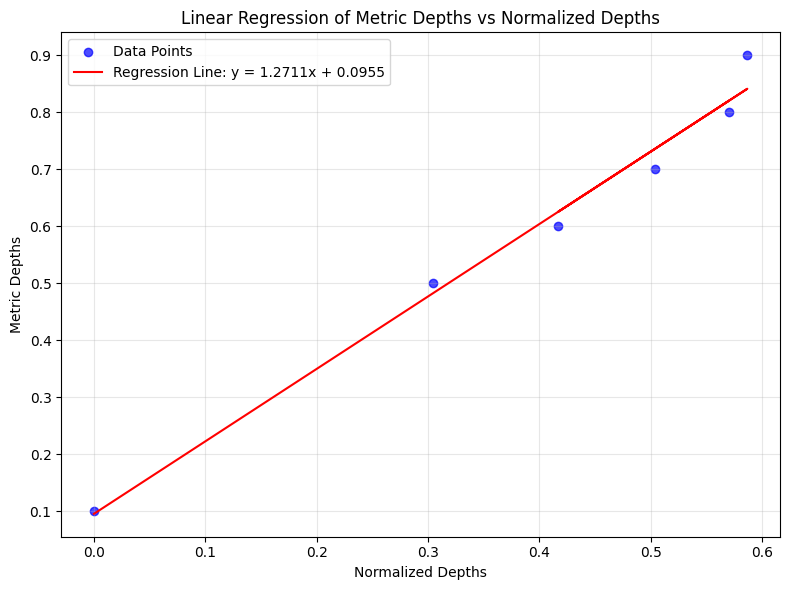

In [145]:
# Generate regression line
regression_line = slope * normalized_depths + intercept

# Plot the data points
plt.figure(figsize=(8, 6))
plt.scatter(normalized_depths, metric_depths, color='blue', label='Data Points', alpha=0.7)

# Plot the regression line
plt.plot(normalized_depths, regression_line, color='red', label=f'Regression Line: y = {slope:.4f}x + {intercept:.4f}')

# Plot
plt.title('Linear Regression of Metric Depths vs Normalized Depths')
plt.xlabel('Normalized Depths')
plt.ylabel('Metric Depths')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# Show the plot
plt.show()

##  Convert Depth Map to Metric Values

In [146]:
if len(valid_normalized_depths) >= 2:
    # Convert the entire depth map to metric depths
    depth_map_metric = slope * depth_values + intercept

    # Reshape back to the original depth map shape
    depth_map_metric = depth_map_metric.reshape(depth_map.shape)

    # Display metric depth map information
    print("Metric depth map created successfully.")
else:
    print("Metric depth map conversion skipped due to insufficient reference points.")

Metric depth map created successfully.


## Plot Depth Map Histogram

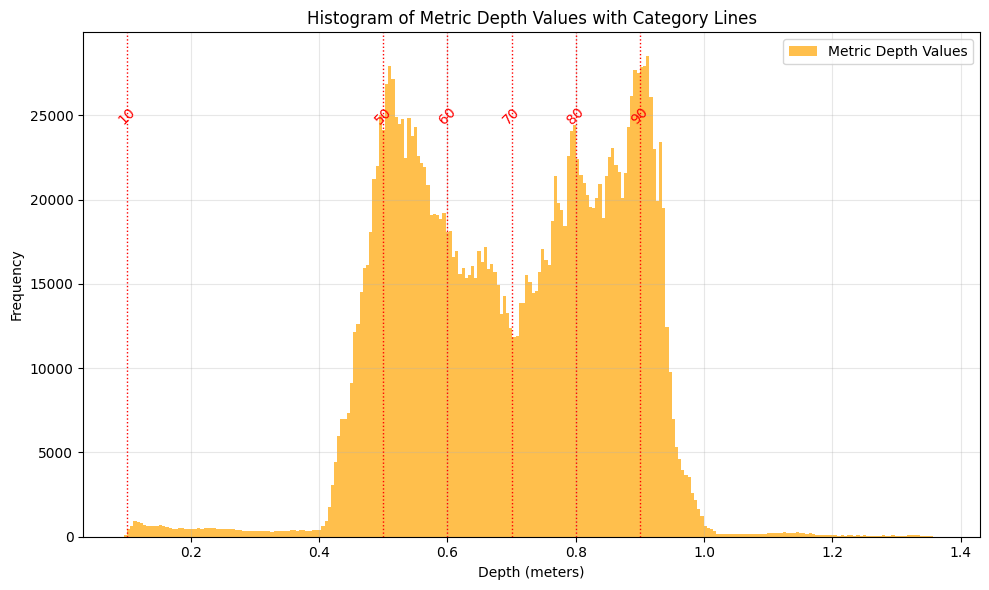

In [147]:
if len(valid_normalized_depths) >= 2:
    # Plot histogram of metric depth values
    plt.figure(figsize=(10, 6))

    # Histogram data
    counts, bins, patches = plt.hist(depth_map_metric.flatten(), bins=256, color='orange', alpha=0.7, label='Metric Depth Values')

    plt.title('Histogram of Metric Depth Values with Category Lines')
    plt.xlabel('Depth (meters)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Get the maximum count from the histogram to position the annotations
    max_count = counts.max()

    # Plot category lines and labels
    for md, category_name in zip(metric_depths, valid_category_names):
        # Plot the vertical line
        plt.axvline(x=md, color='red', linestyle='dotted', linewidth=1)

        # Annotate with the category name
        plt.text(md, max_count * 0.9, str(category_name), rotation=45, color='red', va='top', ha='center')

    plt.tight_layout()
    plt.show()
else:
    print("Not enough reference points to plot metric depth histogram.")

# Coloured Depth Map

Linear regression result: metric_depth = 1.2711 * normalized_depth + 0.0955
R-squared: 0.9848
Metric Depth Map Statistics:
Min: 0.0955 meters
Max: 1.3666 meters


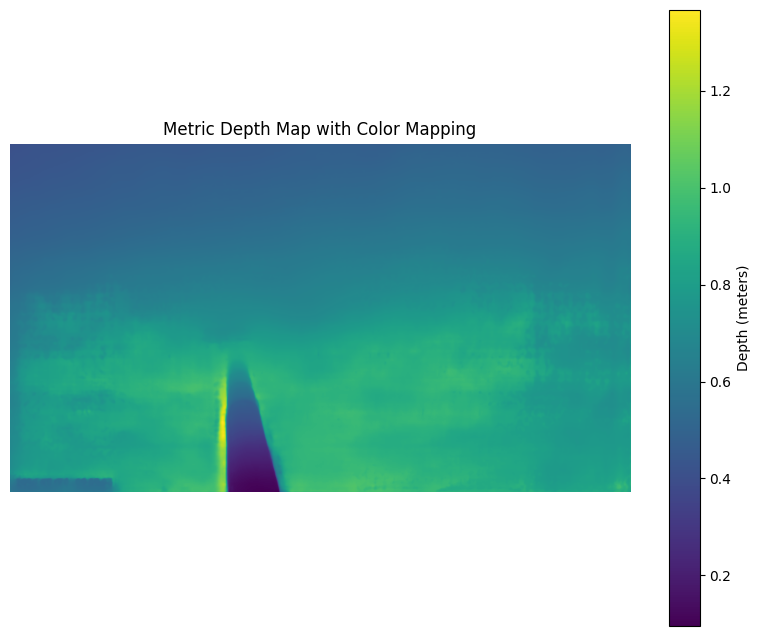

In [148]:
if len(valid_normalized_depths) >= 2:

    # Stats
    print(f"Linear regression result: metric_depth = {slope:.4f} * normalized_depth + {intercept:.4f}")
    print(f"R-squared: {r_value**2:.4f}")
    print(f"Metric Depth Map Statistics:\nMin: {depth_map_metric.min():.4f} meters\nMax: {depth_map_metric.max():.4f} meters")
    
    # Plot metric depth map with color mapping
    plt.figure(figsize=(10, 8))
    plt.imshow(depth_map_metric, cmap='viridis')
    plt.colorbar(label='Depth (meters)')
    plt.title('Metric Depth Map with Color Mapping')
    plt.axis('off')
    plt.show()


### Scale Depth Map and Save as Img

In [128]:
if len(valid_normalized_depths) >= 2:
    # Scaling the metric depth map to 0-255 for visualization
    min_depth = depth_map_metric.min()
    max_depth = depth_map_metric.max()
    depth_map_scaled = (depth_map_metric - min_depth) / (max_depth - min_depth)  # Normalize to 0-1
    depth_map_scaled = (depth_map_scaled * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8

    # Save the scaled depth map as an image
    output_image_path = 'metric_depth_map.png'
    # cv2.imwrite(output_image_path, depth_map_scaled)
    print(f"Metric depth map image saved to {output_image_path}.")


Metric depth map image saved to metric_depth_map.png.


Fitted exponential parameters: a = 0.1936, b = 2.5865


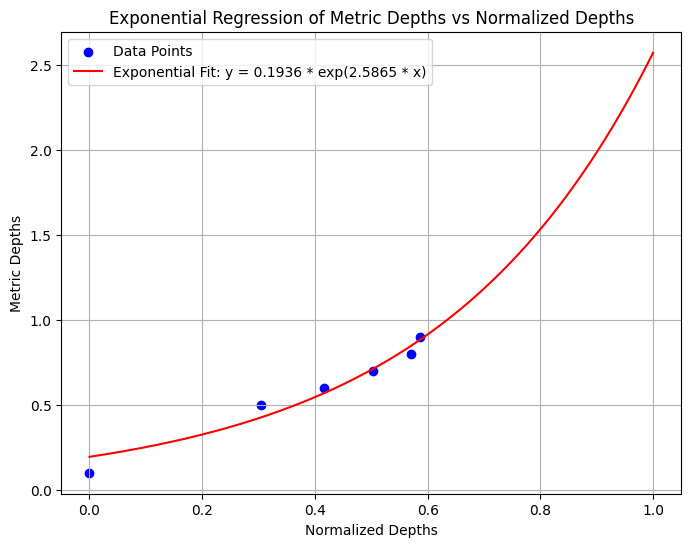

Metric Depth Map Statistics:
Min: 0.1936 meters
Max: 2.5710 meters


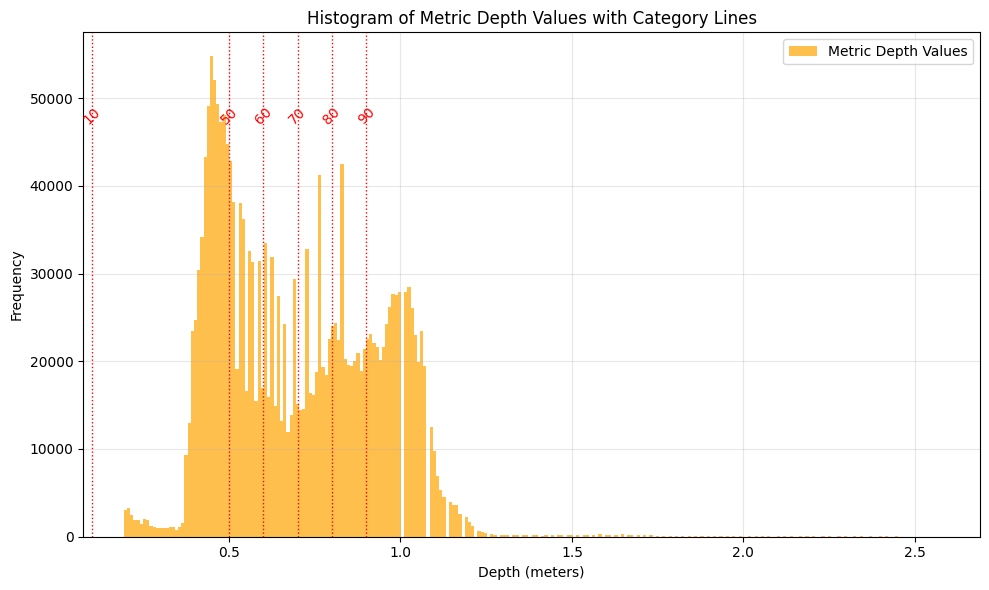

In [149]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define the exponential function
def exponential(x, a, b):
    return a * np.exp(b * x)

# Fit the exponential function to the data
params, covariance = curve_fit(exponential, valid_normalized_depths, metric_depths, p0=(0.1, 0.1))

# Extract fitted parameters
a, b = params
print(f"Fitted exponential parameters: a = {a:.4f}, b = {b:.4f}")

# Generate predictions using the fitted model
x = np.linspace(0, 1, 1000)  # Normalized depth range
y = exponential(x, a, b)

# Plot the original data and the exponential fit
plt.figure(figsize=(8, 6))
plt.scatter(valid_normalized_depths, metric_depths, color='blue', label='Data Points')
plt.plot(x, y, color='red', label=f'Exponential Fit: y = {a:.4f} * exp({b:.4f} * x)')
plt.xlabel('Normalized Depths')
plt.ylabel('Metric Depths')
plt.title('Exponential Regression of Metric Depths vs Normalized Depths')
plt.legend()
plt.grid()
plt.show()

# Apply the exponential model to convert the depth map
depth_map_metric = exponential(depth_values, a, b)

# Reshape back to the original depth map shape
depth_map_metric = depth_map_metric.reshape(depth_map.shape)

# Print basic statistics
print(f"Metric Depth Map Statistics:\nMin: {depth_map_metric.min():.4f} meters\nMax: {depth_map_metric.max():.4f} meters")

# Plot the metric depth map histogram with category lines
plt.figure(figsize=(10, 6))

# Histogram data
counts, bins, patches = plt.hist(depth_map_metric.flatten(), bins=256, color='orange', alpha=0.7, label='Metric Depth Values')

# Add category lines and annotations
for md, category_name in zip(metric_depths, valid_category_names):
    plt.axvline(x=md, color='red', linestyle='dotted', linewidth=1)
    plt.text(md, counts.max() * 0.9, str(category_name), rotation=45, color='red', va='top', ha='center')

# Customize the plot
plt.title('Histogram of Metric Depth Values with Category Lines')
plt.xlabel('Depth (meters)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
